In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date=(session.query(Measurement.date)
                    .order_by(Measurement.date.desc())
                    .first())
latest_date

('2017-08-23')

Query Date: 2016-08-22


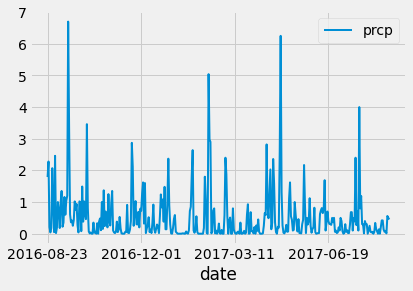

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago_date=dt.date(2017, 8, 23) - dt.timedelta(days=366)
print('Query Date:', year_ago_date)

# Perform a query to retrieve the data and precipitation scores
year_precip=(session.query(Measurement.date,func.max(Measurement.prcp))
                  .filter(func.strftime('%Y-%m-%d',Measurement.date) > year_ago_date)
                  .group_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df=pd.DataFrame(year_precip, columns=['date', 'prcp'])
precip_df.set_index('date',inplace=True)

# Sort the dataframe by date
precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(linewidth=2,alpha=1,rot=0)

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(Station).count()

print(f'{total_stations}')

9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity=(session.query(Measurement.station,func.count(Measurement.station))
                         .group_by(Measurement.station)
                         .order_by(func.count(Measurement.station).desc())
                         .all())
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs=[Measurement.station, 
             func.min(Measurement.tobs), 
             func.max(Measurement.tobs), 
             func.avg(Measurement.tobs)]

most_active_station=(session.query(*tobs)
                       .filter(Measurement.station=='USC00519281')
                       .all())
#most_active_station

most_active_station_temp=pd.DataFrame(most_active_station, columns=['station', 'min_temp', 
                                                          'max_temp', 'avg_temp'])
most_active_station_temp.set_index('station', inplace=True)
most_active_station_temp

,min_temp,max_temp,avg_temp
station,,,
USC00519281,54.0,85.0,71.663781


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <BarContainer object of 12 artists>)

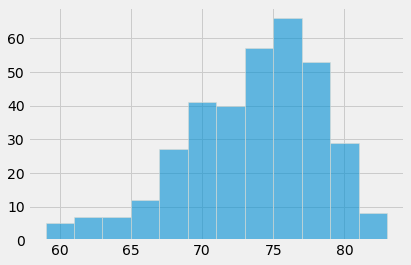

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_tobs=(session.query(Measurement.date,(Measurement.tobs))
                  .filter(func.strftime(Measurement.date) > year_ago_date)
                  .filter(Measurement.station=='USC00519281')
                  .all())
tobs_df=pd.DataFrame(year_tobs)
tobs_df.set_index('date',inplace=True)

plt.hist(tobs_df['tobs'],bins=12,alpha=0.6,linewidth=1,
         edgecolor='xkcd:light gray')

# Close session

In [15]:
# Close Session
session.close()